# How To Run a Jackknife Using Hera_Stats

This code shows how to use the jackknifing class in hera_stats.

First, I will run everything systematically. Later, all at once in an overarching function.

In [1]:
# Import stuff
%matplotlib inline
import hera_stats as hs
import matplotlib.pyplot as plt
from pyuvdata import UVData
import hera_pspec as hp
import copy

/users/drocha/Python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


First, to calculate a UVPSpec in the most simple way possible:

In [2]:
# Load UVData miriad file from filepath
filepath = "../hera_stats/data/gaussian.N18.2018-06-06.06_15_48/"
uvd = UVData()
uvd.read_miriad(filepath)

In [3]:
# Set some specifications
beampath = "../hera_stats/data/NF_HERA_Beams.beamfits"

# Calculate power spectra
cosmo = hp.conversions.Cosmo_Conversions()
beam = hp.PSpecBeamUV(beampath, cosmo=cosmo)
ds = hp.PSpecData([uvd, uvd], [None, None], beam=beam)
blpairs = [p for p in uvd.get_antpairs() if p[0]+1 == p[1]]

bsl1, bsl2, blpairs = hp.utils.construct_blpairs(blpairs,
                                                 exclude_auto_bls=True,
                                                 exclude_permutations=True)
uvp = ds.pspec(bsl1, bsl2, (0,1), ("XX", "XX"), spw_ranges=[(600,610)], verbose=True)


Setting spectral range: (600, 610)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((0, 1), (1, 2))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (11, 12))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (12, 13))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (13, 14))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (23, 24))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (24, 25))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 1), (25, 26))
pol: (-5, -5)
  Building q_h

Now, we can look at a few of the jackknives possible. The first, splitting by antenna. This one splits the antenna into two groups randomly, and splits the UVPSpec into two based on these antenna groups.

In [4]:
# Split antenna into two groups
uvpl = hs.jackknives.split_ants(uvp, n_jacks=4)

In [5]:
# have a look at the uvp list. It's a list of pairs:
uvpl

[[<hera_pspec.uvpspec.UVPSpec at 0x7f35f1988b10>,

In [6]:
# Currently I just store the group name in labels.
for i, uv in enumerate(uvpl):
    print "jackknife number %i:" % i
    print "  --group 1:", sorted(uvpl[0][0].labels)
    print "  --group 2:", sorted(uvpl[i][1].labels)

jackknife number 0:
  --group 1: [1, 11, 13, 14, 23, 24, 25, 26, 27]
  --group 2: [0, 2, 12, 36, 37, 38, 39, 40, 41]
jackknife number 1:
  --group 1: [1, 11, 13, 14, 23, 24, 25, 26, 27]
  --group 2: [1, 2, 12, 13, 14, 25, 26, 27, 41]
jackknife number 2:
  --group 1: [1, 11, 13, 14, 23, 24, 25, 26, 27]
  --group 2: [0, 11, 12, 14, 25, 26, 27, 39, 40]
jackknife number 3:
  --group 1: [1, 11, 13, 14, 23, 24, 25, 26, 27]
  --group 2: [0, 1, 2, 23, 26, 27, 37, 40, 41]


In [7]:
# Also stored is a temporary class variable .jkftype:
print uvpl[0][0].jkftype

spl_ants


The next jackknife splits the data into groups based on the time. It looks for recurring events.

In [8]:
uvpl = hs.jackknives.split_times(uvp, periods=100)

(2458098.3641287405, 2458098.3710881784)

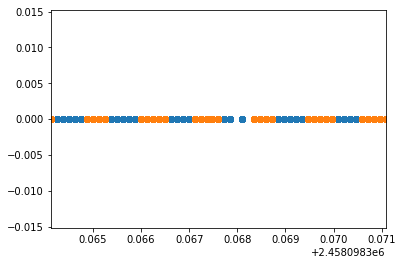

In [9]:
# This plots each time sample as a point along the x axis, and the color is
# the group in which the sample was placed.
for uv in uvpl[0]:
    plt.scatter(uv.time_avg_array, [0]*len(uv.time_avg_array))

plt.xlim(min(uv.time_avg_array), max(uv.time_avg_array))

Finally, there is split_files, which takes a list of UVPSpecs and the filenames, and splits them into groups based on an identifier in the filename. For example:

In [10]:
# Lets create a fake group of files (pretend that all of the UVPSpecs in 
# uvp_files were loaded separately).
uvp_files = [copy.deepcopy(uvp) for i in range(10)]
filenames = ["GroupA"]*5 + ["GroupB"]*5

In [11]:
uvpl = hs.jackknives.split_files(uvp_files, filenames, "A")

In [12]:
# So you can see, 
for i, uv in enumerate(uvpl):
    print "Filepair %i:" % i
    print "  --", uv[0].labels
    print "  --", uv[1].labels

Filepair 0:
  -- ['GroupA']
  -- ['GroupB']
Filepair 1:
  -- ['GroupA']
  -- ['GroupB']
Filepair 2:
  -- ['GroupA']
  -- ['GroupB']
Filepair 3:
  -- ['GroupA']
  -- ['GroupB']
Filepair 4:
  -- ['GroupA']
  -- ['GroupB']


Finally, bootstrapping and saving. If the UVPSpecs are in this format, a list of lists, then the bootstrapping is easy:

In [13]:
# Generally, higher n_boots will be used
uvpl_booted = hs.jackknives.bootstrap_jackknife(uvpl, n_boots=5)

And saving would be the following:

```
hs.jackknives.save_jackknife(uvpl, savename="whatever")
```